In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ISLP.models
from statsmodels.api import add_constant, OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 多元线性回归

## 概述
本笔记本使用“波士顿”数据集来探索多元线性回归，目的是研究如何利用多个变量预测数据行为，并理解在回归模型中包含多个预测变量的影响。您将学习如何：

- 在 `matplotlib` 中可视化 3D 数据
- 使用普通最小二乘回归（OLS）拟合高维数据
- 通过 p 值计算确定变量的相关性
- 通过计算方差膨胀因子（VIF）探索变量间的多重共线性

## 加载演示数据

我们将从 ISLP 包中加载 "Boston" 示例数据集。该数据集来源于 Harrison 和 Rubinfeld 于 1978 年进行的一项题为《享乐价格与清洁空气的需求》的研究，包含了波士顿 506 个郊区的信息。

In [2]:
data_boston = ISLP.load_data("Boston")

### 探索多个变量

让我们绘制 `lstat` 和 `age` 列与 `medv` 的关系图。

快速回顾：

**`age`**
- **定义**：1940 年前建成的自住房单元的比例。
- **示例**：值为 `60` 表示 60% 的房屋建于 1940 年之前。

**`lstat`**
- **定义**：低收入人口的百分比。
- **示例**：值为 `12.0` 表示该镇 12% 的人口被认为处于较低的社会经济地位。

**`medv`**
- **定义**：自住房的中位数价值（以千美元计）。
- **示例**：值为 `24.0` 表示中位数房价为 24,000 美元。

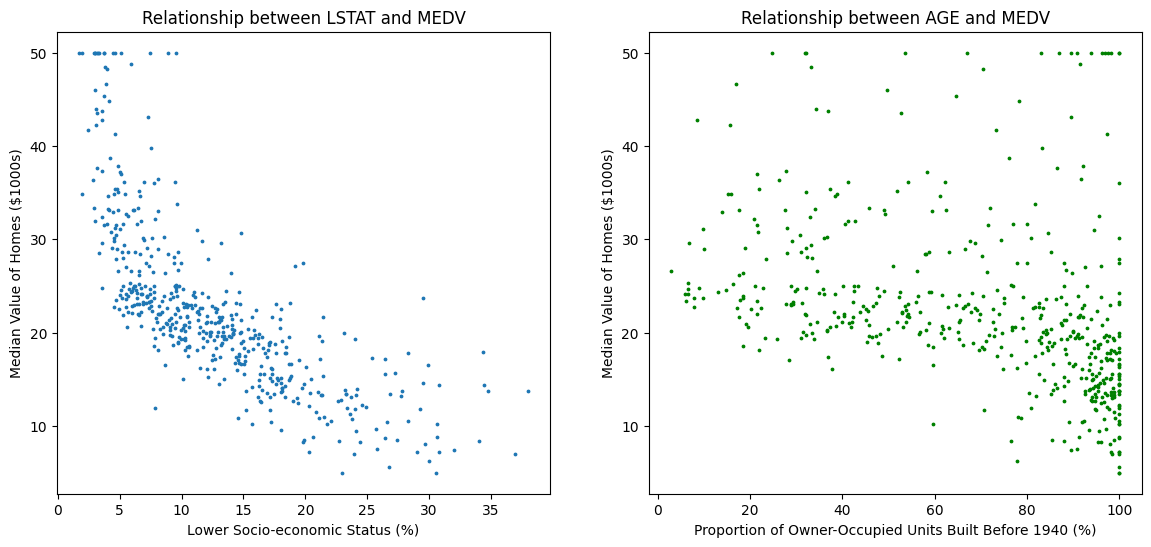

In [3]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

axes[0].scatter(
    data_boston['lstat'],
    data_boston['medv'],
    s=3, 
)
axes[0].set_xlabel('Lower Socio-economic Status (%)')
axes[0].set_ylabel('Median Value of Homes ($1000s)')
axes[0].set_title('Relationship between LSTAT and MEDV')


axes[1].scatter(
    data_boston['age'],
    data_boston['medv'],
    c='g',
    s=3, 
)
axes[1].set_xlabel('Proportion of Owner-Occupied Units Built Before 1940 (%)')
axes[1].set_ylabel('Median Value of Homes ($1000s)')
axes[1].set_title('Relationship between AGE and MEDV')

plt.show()

我们将使用设计矩阵方法来探索变量与响应变量之间的线性关系。线性模型与之前相同：

$$
\mathbf{y} = X \mathbf{\beta} + \mathbf{\epsilon} 
$$

由于 ($X$) 矩阵中有三列，因此 ($\beta$) 是一个包含三个分量的向量：

$$
\mathbf{y} = \mathbf{\beta_0} + X_{\text{lstat}}\mathbf{\beta_1} + X_{\text{age}}\mathbf{\beta_2} + \mathbf{\epsilon} 
$$

## 实现

与单变量线性回归类似，我们将构建一个包含所有感兴趣变量的矩阵，并使用普通最小二乘（OLS）方法来优化线性拟合。

In [4]:
data_num_of_rows = data_boston["lstat"].shape[0]

x_matrix = add_constant(data_boston[["lstat", "age"]])
y = data_boston["medv"]

model_age_lstat = OLS(y, x_matrix)
results = model_age_lstat.fit()
results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           2.98e-88
Time:                        02:54:50   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2228      0.731     45.458      0.0

当我们在 `x_matrix` 中添加一个新列时，我们相当于在拟合中增加了一个维度。

在进行单变量回归拟合时，我们对数据拟合一条线。而当添加一个新列后，我们在拟合中加入了额外的维度。让我们构建一个 3D 散点图（1 个响应变量 + 2 个自变量）来直观地展示这种多维关系。

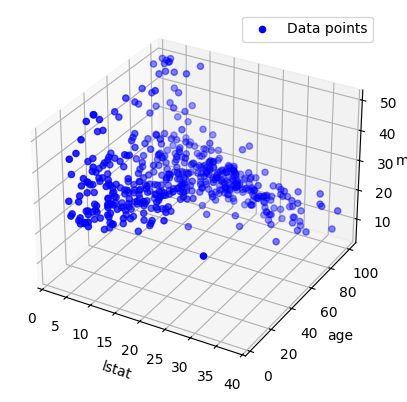

In [5]:
fig = plt.figure()
ax_3D = fig.add_subplot(111, projection="3d")

ax_3D.scatter(
    data_boston["lstat"],
    data_boston["age"],
    data_boston["medv"],
    color="blue",
    label="Data points",
)

ax_3D.set_xlabel("lstat")
ax_3D.set_ylabel("age")
ax_3D.set_zlabel("medv")
ax_3D.legend()

plt.show()

在对这 3D 数据执行线性回归时，我们将所有数据点拟合到一个平面上。以下是使用 `matplotlib` 可视化拟合平面的一种方法：

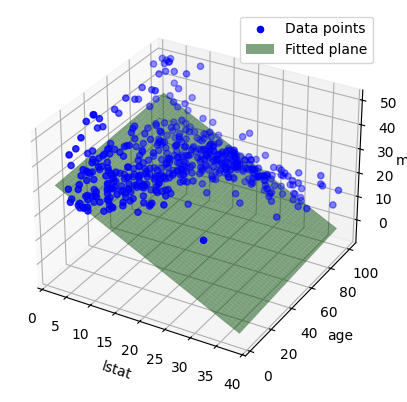

In [6]:
# setup a grid to plot the plane
lstat_range = np.linspace(data_boston["lstat"].min(), data_boston["lstat"].max(), 50)
age_range = np.linspace(data_boston["age"].min(), data_boston["age"].max(), 50)
lstat_grid, age_grid = np.meshgrid(lstat_range, age_range)

# Get the predicted values on the grid
X_grid = np.column_stack(
    [np.ones(lstat_grid.ravel().shape), lstat_grid.ravel(), age_grid.ravel()]
)
y_hat = results.predict(X_grid)
y_hat_grid = y_hat.reshape(lstat_grid.shape)


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    data_boston["lstat"],
    data_boston["age"],
    data_boston["medv"],
    color="blue",
    label="Data points",
)

ax.plot_surface(
    lstat_grid, age_grid, y_hat_grid, color="green", alpha=0.5, label="Fitted plane"
)

ax.set_xlabel("lstat")
ax.set_ylabel("age")
ax.set_zlabel("medv")
ax.legend()

plt.show()

## 高维数据

当我们只有一个变量（2D）或两个变量（3D）时，数据可视化相对简单，可以确认线性关系是否适合该数据。然而，大多数情况下，我们需要处理多维数据，此时可视化并不容易。

让我们开始拟合数据集中的所有变量（列），当然不包括 `medv` 列。

In [7]:
x_matrix = data_boston.drop(columns=["medv"])
x_matrix = add_constant(x_matrix)

y = data_boston["medv"]

x_matrix = x_matrix.iloc[:, :13]
print(x_matrix.shape)

results = OLS(y, x_matrix).fit()
print(results.summary())

(506, 13)
                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          2.23e-133
Time:                        02:54:51   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6173      4.936      8.43

In [8]:
ols_results = pd.DataFrame(
    {
        "Coefficients": results.params,
        "P-values": results.pvalues,
        "Standard Errors": results.bse,
        "t-values": results.tvalues,
        "Confidence Interval Lower Bound": results.conf_int()[0],
        "Confidence Interval Upper Bound": results.conf_int()[1],
    }
)
p_sorted_df = ols_results.sort_values("P-values")
p_sorted_df

,Coefficients,P-values,Standard Errors,t-values,Confidence Interval Lower Bound,Confidence Interval Upper Bound
lstat,-0.552019,6.392118e-25,0.050659,-10.896814,-0.651553,-0.452485
rm,3.658119,4.808025e-17,0.420246,8.704714,2.832425,4.483813
const,41.617270,3.794467e-16,4.936039,8.431308,31.919001,51.315539
dis,-1.490754,6.170894e-13,0.201623,-7.393779,-1.886899,-1.094608
ptratio,-0.937533,4.630167e-12,0.132206,-7.091443,-1.197290,-0.677776
nox,-18.758022,1.502073e-06,3.851355,-4.870500,-26.325116,-11.190928
rad,0.289405,1.843595e-05,0.066908,4.325417,0.157945,0.420864
crim,-0.121389,2.605302e-04,0.033000,-3.678399,-0.186227,-0.056550
zn,0.046963,7.719966e-04,0.013879,3.383750,0.019694,0.074233
tax,-0.012682,9.124487e-04,0.003801,-3.336504,-0.020150,-0.005214


### 前向选择

我们从空模型开始（仅包含截距，不包含预测变量）。然后拟合 m 个简单线性回归模型（m 是感兴趣变量的数量），并将 p 值最低的变量添加到空模型中。接着，在此模型的基础上添加使 **新双变量模型** 的 p 值最低的变量。此方法持续进行，直到满足某个停止规则。以下是实现代码：

In [9]:
def get_variable_for_forward_selction(
    model_variables, response, data_frame, candidate_variables
):
    """
    Identifies the next variable to include in a forward selection process
    based on the lowest p-value.

    Parameters:
    -----------
    model_variables : list
        A list of variables already included in the model.
    response : pandas.Series
        The dependent variable or response to be predicted.
    data_frame : pandas.DataFrame
        The dataset containing the model and candidate variables.
    candidate_variables : list
        A list of variables considered for inclusion in the model.

    Returns:
    --------
    str
        The name of the variable from 'candidate_variables' that has the
        lowest p-value when added to the model.
    """
    list_of_p_values = []
    for var in candidate_variables:
        new_model_vars = model_variables + [var]
        x_matrix = add_constant(data_frame[new_model_vars])
        model = OLS(response, x_matrix)
        results = model.fit()
        list_of_p_values.append(
            {
                "var": var,
                "P-values": results.pvalues.iloc[-1],
            }
        )
    df_p_values = pd.DataFrame(list_of_p_values).sort_values("P-values")
    return df_p_values["var"].iloc[0]

[['lstat', 'rm', 'ptratio', 'dis', 'nox', 'chas', 'zn', 'crim', 'rad', 'tax']]
[['lstat', 'rm', 'ptratio', 'dis', 'nox', 'chas', 'zn', 'crim', 'rad', 'tax']]


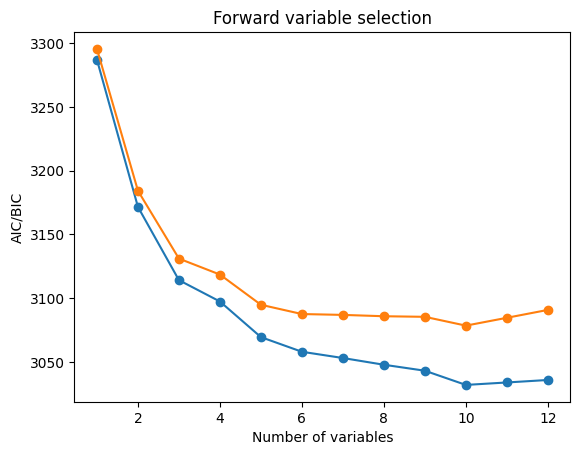

In [10]:
y = data_boston["medv"]

candidate_vars = data_boston.drop(columns=["medv"]).columns.tolist()
num_of_forward_steps = len(candidate_vars)

model_vars = []
results_list = []
for _ in range(num_of_forward_steps):
    selected_var = get_variable_for_forward_selction(
        model_vars, y, data_boston, candidate_vars
    )
    model_vars.append(selected_var)
    candidate_vars = [var for var in candidate_vars if var not in model_vars]

    x_matrix = add_constant(data_boston[model_vars])
    model = OLS(y, x_matrix)
    results = model.fit()
    results_list.append(
        {
            "Number of Variables": len(model_vars),
            "Variables": model_vars.copy(),
            "AIC": results.aic,
            "BIC": results.bic,
        }
    )
df_results = pd.DataFrame(results_list)


plt.plot(df_results["Number of Variables"], df_results["AIC"], "o-", label="AIC")
plt.plot(df_results["Number of Variables"], df_results["BIC"], "o-", label="BIC")
plt.title("Forward variable selection")
plt.ylabel("AIC/BIC")
plt.xlabel("Number of variables")

print(df_results[df_results["AIC"] == min(df_results["AIC"])]["Variables"].tolist())
print(df_results[df_results["BIC"] == min(df_results["BIC"])]["Variables"].tolist())

## 方差膨胀因子（VIF）

VIF 用于量化由于预测变量间的多重共线性而导致回归系数方差膨胀的程度。当回归模型中的两个或多个预测变量高度相关时，会产生多重共线性，从而使得难以确定每个预测变量对响应变量的单独影响。预测变量 $X_i$ 的 VIF 计算公式为：

$$
VIF(X_i) = \frac{1}{1 - R_i^2}
$$

其中，$R_i^2$ 是在所有其他预测变量上回归 $X_i$ 得到的 $R^2$ 值。

### VIF 值的解释：
- VIF $= 1$：预测变量与其他变量之间没有相关性，意味着没有膨胀。
- $1 <$ VIF $< 5$：中等相关性，在许多情况下可以接受。
- VIF $> 5$：高相关性，表明可能存在多重共线性问题。
- VIF $> 10$：严重多重共线性，建议解决此问题，可以通过移除/合并预测变量或使用主成分分析（PCA）等降维技术。

我们将使用 `statsmodels` 库计算所有变量的 VIF 值。注意，不需要包括“截距”（位于第 0 列）。

In [11]:
vif_vals = [variance_inflation_factor(x_matrix, i) for i in range(1, x_matrix.shape[1])]
vif_df = pd.DataFrame(
    {"vif": vif_vals},
    index=x_matrix.columns[1:],
)
vif_df

,vif
lstat,2.870777
rm,1.912532
ptratio,1.797060
dis,3.954037
nox,4.369093
chas,1.071168
zn,2.298459
crim,1.767486
rad,7.445301
tax,9.002158


# 轮到你了！
- 请解释 VIF 结果。
- 哪些变量高度相关？
- 我们如何进一步剔除不必要的变量？